# Load and visualize pairs of (galaxy image, galaxy spectrum)

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_parquet('data/train-00000-of-00138-de54d6200ce4d5fa.parquet')

/home/jeremiasrodriguez/miniconda3/envs/astroclip/lib/python3.9/site-packages/pyarrow/parquet/core.py:1329: RuntimeWarning: pickle-based deserialization of pyarrow.PyExtensionType subclasses is disabled by default; if you only ingest trusted data files, you may re-enable this using `pyarrow.PyExtensionType.set_auto_load(True)`.
In the future, Python-defined extension subclasses should derive from pyarrow.ExtensionType (not pyarrow.PyExtensionType) and implement their own serialization mechanism.

  [fragment], schema=schema or fragment.physical_schema,
/home/jeremiasrodriguez/miniconda3/envs/astroclip/lib/python3.9/site-packages/pyarrow/parquet/core.py:1329: FutureWarning: pyarrow.PyExtensionType is deprecated and will refuse deserialization by default. Instead, please derive from pyarrow.ExtensionType and implement your own serialization mechanism.
  [fragment], schema=schema or fragment.physical_schema,
/home/jeremiasrodriguez/miniconda3/envs/astroclip/lib/python3.9/site-packages/pya

In [2]:
print("Shape of dataset: ", df.shape)
print("Columns: ", df.columns)

Shape of dataset:  (1148, 4)
Columns:  Index(['image', 'spectrum', 'redshift', 'targetid'], dtype='object')


In [47]:
start = 3600
end = 9824
step = 0.8

number_list = [x for x in range(int(start * 10), int(end * 10), int(step * 10))]
wavelength_domain = [x / 10 for x in number_list]  # Converting back to original scale

print(len(wavelength_domain))

7780


In [48]:
def plot_galaxy(idx):
    image = df['image'][idx]
    spectrum = df['spectrum'][idx]
    redshift = df['redshift'][idx]
    targetid = df['targetid'][idx]
    image_array = np.array(image)

    # Now, extract RGB values into a flat structure first
    # Here we create a list of lists to gather RGB values
    rgb_values = []
    
    for row in image_array:
        # Each row is expected to be an array of shape (152,)
        rgb_row = [pixel for pixel in row]  # Each pixel is an array of shape (3,)
        rgb_values.append(rgb_row)
    
    # Convert to a numpy array
    rgb_values = np.array(rgb_values) #Adding a super random multiplier just to try to visualize this better.
    normalized_image = np.clip(rgb_values, 0, None)  # Remove negatives
    normalized_image = normalized_image / np.max(normalized_image)  # Scale to [0, 1]
    
    # Convert to uint8 for proper visualization
    visual_image = (normalized_image * 255).astype(np.uint8)
    
    # Plot the image
    plt.title(f'Galaxy ID: {targetid}')  # Use targetid for identification
    plt.imshow(visual_image)
    plt.axis('off')  # Turn off axis
    plt.show()

In [49]:
def plot_spectrum(df, idx):
    spectrum = df['spectrum'][idx]
    plt.figure(figsize=(12, 3))  # Adjust figsize as needed
    # Plot the spectrum
    plt.plot(wavelength_domain,spectrum[:-1])
    
    # Set title or labels if needed
    plt.title(f'Spectrum ID: {df["targetid"][idx]}')  # Use targetid for identification
    plt.xlabel('Wavelength [Angstrom]')  # Replace with actual x-axis label if available
    plt.ylabel('Intensity')    # Replace with actual y-axis label if available
    
    plt.show()  # Show each spectrum one after another


# Examples

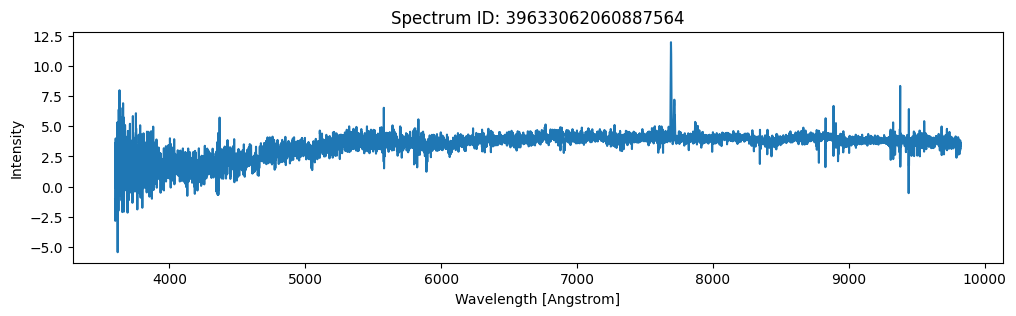

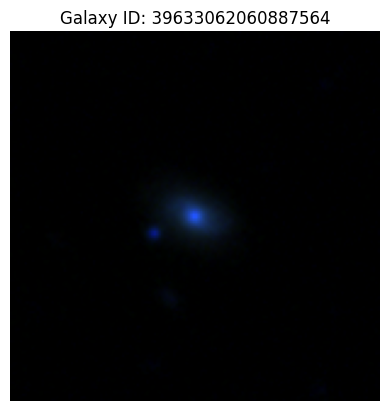

In [50]:
plot_spectrum(df,0)
plot_galaxy(0)

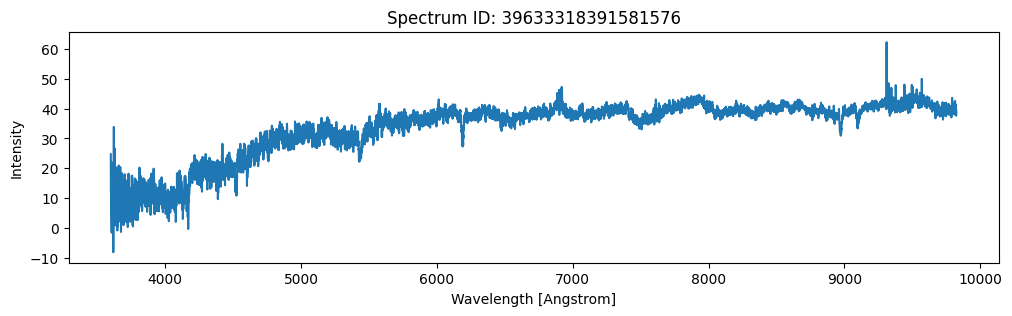

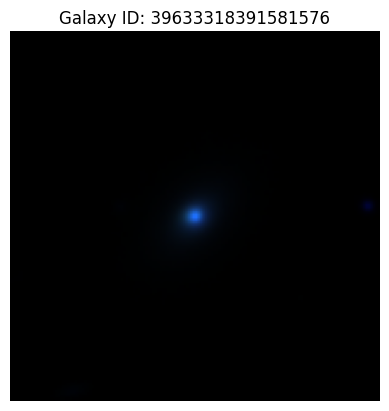

In [51]:
plot_spectrum(df,100)
plot_galaxy(100)

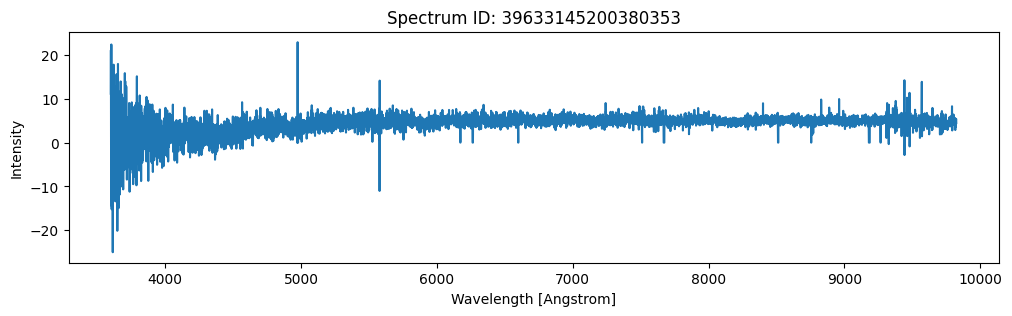

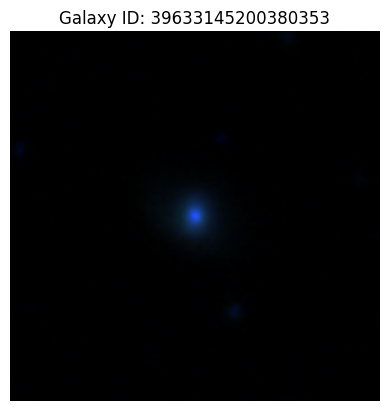

In [52]:
plot_spectrum(df,1000)
plot_galaxy(1000)

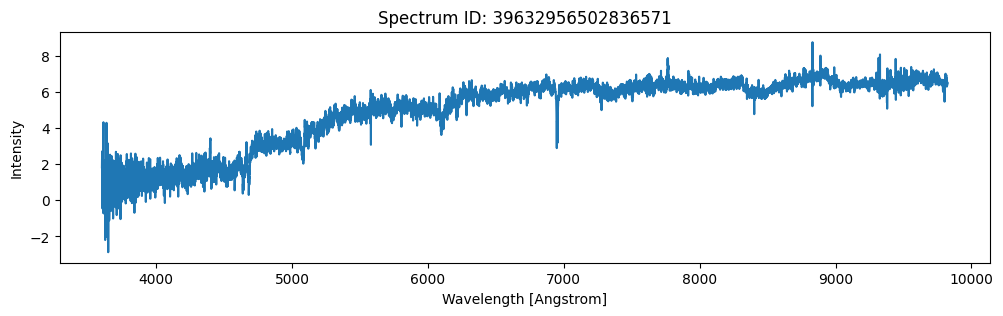

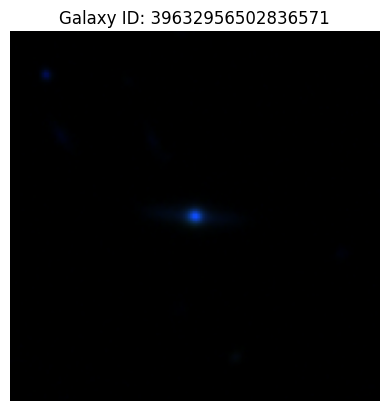

In [54]:
plot_spectrum(df,900)
plot_galaxy(900)

# Band response functions

In [10]:
# Step 1: Load the DESI filter response curves
import speclite.filters 

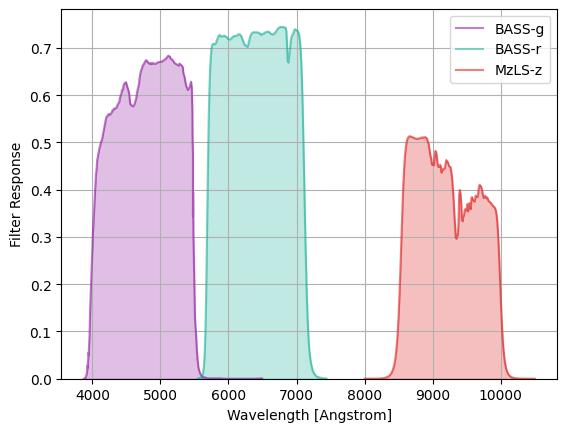

In [11]:
desi_imaging = speclite.filters.load_filters('BASS-g', 'BASS-r', 'MzLS-z')
speclite.filters.plot_filters(desi_imaging)

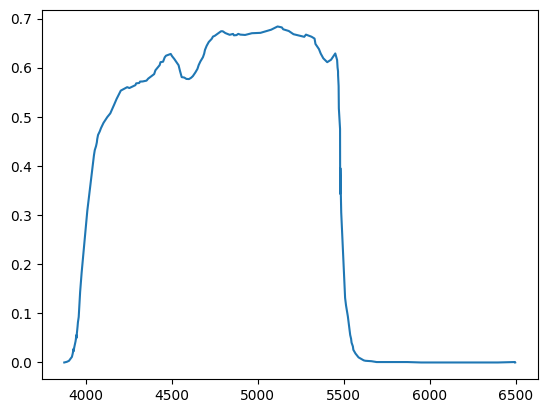

In [55]:
g_band_wavelenght = desi_imaging[0]._wavelength
g_band_response = desi_imaging[0]._response
plt.plot(g_band_wavelenght,g_band_response)

# Manually calculate k-corrections (integrating the spectrum)

In [82]:
import numpy as np
from scipy.integrate import simps
from scipy.interpolate import interp1d

In [88]:
import numpy as np
from scipy.integrate import simpson

def k_correction(wavelength_obs_angstrom, flux_obs_obs, wavelength_trans_angstrom, trans_func, z):
    # Conversion factor
    angstrom_to_meter = 1e-10  # 1 angstrom = 1e-10 meters

    # Convert wavelengths from Angstrom to meters (ensuring they are numpy arrays)
    wavelength_obs = np.array(wavelength_obs_angstrom) * angstrom_to_meter
    wavelength_trans = np.array(wavelength_trans_angstrom) * angstrom_to_meter

    # Rest-frame wavelengths (observed wavelength divided by 1 + z)
    wavelength_rest = wavelength_obs / (1 + z)

    # Interpolate the transmission function to match the observed wavelengths
    trans_interp = np.interp(wavelength_rest, wavelength_trans, trans_func)

    # Calculate the observed-frame integral
    observed_integral = simpson(flux_obs_obs * trans_interp, x=wavelength_obs)

    # Calculate the rest-frame integral
    rest_frame_integral = simpson(flux_obs_obs * trans_interp, x=wavelength_rest)

    # K-correction formula
    k_corr = -2.5 * np.log10(rest_frame_integral / observed_integral)

    return k_corr


In [89]:
# Example inputs (in angstroms and flux_obs in 10^-17 erg/s/cm^2/Å)

idx = 0
spectrum = df['spectrum'][idx]

z = df['redshift'][idx] # redshift
wavelength_obs_angstrom = np.array(wavelength_domain)  # in Angstrom
flux_obs_obs = np.concatenate(spectrum[:-1])  # in 10^-17 erg/s/cm^2/Å
wavelength_trans_angstrom = speclite.filters.load_filters('BASS-g')[0]._wavelength  # in Angstrom
trans_func = speclite.filters.load_filters('BASS-g')[0]._response  # Transmission function [0, 1]


k_correction(wavelength_obs_angstrom, flux_obs_obs, wavelength_trans_angstrom, trans_func, z)

0.17215135370294912

# Use k-correct to try to approximate this value

In [95]:
import kcorrect.kcorrect

In [101]:
# Step 1: Interpolate the flux onto the wavelengths of the response function
interpolator = interp1d(wavelength_obs_angstrom, flux_obs, bounds_error=False, fill_value=0)
flux_interp = interpolator(wavelength_trans_angstrom)

# Step 2: Convolve the interpolated flux with the response function
# Assuming that both arrays are of the same length after interpolation
convolved_flux = flux_interp * trans_func

# Step 3: Integrate to find total flux in the band
integrated_flux = simpson(convolved_flux, x=wavelength_trans_angstrom)

# Step 4: Convert integrated flux to maggies
# Normalization factor: 1 maggie = 1e-9 erg/s/cm^2
maggies = integrated_flux * (1e-9)  # Adjust if you need a different scaling

print(f"Integrated Flux: {integrated_flux} erg/s/cm^2")
print(f"Maggies: {maggies} maggies")

Integrated Flux: 2502.3298525588134 erg/s/cm^2
Maggies: 2.5023298525588135e-06 maggies
